In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
from torchvision import transforms
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.patches as patches
import math
import clip
import requests
import torchvision
from PIL import Image
from io import BytesIO
import torch.nn.functional as F
import torchvision.transforms as transforms

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


import natsort
import os
import shutil

## dataset

In [2]:
folder = '/home/robot/Desktop/CLIP/kudamm'
dirlist = os.listdir(folder)
dirlist = natsort.natsorted(dirlist)

## CLIP model, device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocessor = clip.load('ViT-B/32', device)

## Edgebox

In [4]:
def edgebox(modelfile, img, num):
    file = modelfile
    im = cv2.imread(img)
    #http://amroamroamro.github.io/mexopencv/opencv_contrib/structured_edge_detection_demo.html
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(modelfile)
    rgb_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    edges = edge_detection.detectEdges(np.float32(rgb_im) / 255.0)
    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(num)
    boxes = edge_boxes.getBoundingBoxes(edges, orimap)
    
    return boxes

## (x,y,w,h) -> (x_min, y_min, x_max, y_max)

In [5]:
#(x,y,w,h) -> (min, max)
def min_max(bbx):
    region = []
    for i in bbx:
        region.append([i[0], i[1], i[0] + i[2], i[1] + i[3]])
    
    edgebox = torch.tensor(region)
    
    return edgebox

## Plot image

In [6]:
def plot_image_edgebox(image, boxes):
    image_ori = cv2.imread(image)
    for b in boxes:
        x, y, w, h = b
        cv2.rectangle(image_ori, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        
    imgRGB = cv2.cvtColor(image_ori, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(imgRGB)
    plt.show()

In [7]:
def plot_image_with_boxes_each(image, boxes, result):
    for box, label in zip(boxes, result):
        fig, ax = plt.subplots()
        ax.imshow(transforms.ToPILImage()(image))
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='green')
        ax.add_patch(rect)
        if labels is not None:
            label_size = len(result) * 10
            ax.text(x_min + (x_max - x_min) / 2 - label_size / 2, y_min, label, fontsize=10, verticalalignment='top', color='red')
        plt.tight_layout()
        plt.axis('off')
        plt.show()

In [8]:
def plot_image_with_boxes_all(image, boxes, labels):
    fig, ax = plt.subplots()
    ax.imshow(transforms.ToPILImage()(image))
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='green')
        ax.add_patch(rect)
        if labels is not None:
            label_size = len(labels) * 10
            ax.text(x_min + (x_max - x_min) / 2 - label_size / 2, y_min, labels[i], fontsize=10, verticalalignment='top', color='red')

    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [9]:
def plot_dictionary(label_dict):
    myList = label_dict.items()
    myList = sorted(myList)
    x, y = zip(*myList)

    plt.figure(figsize=(20, 5))
    plt.plot(x, y,color='skyblue',
         marker='o', markerfacecolor='blue',
         markersize=6)
    plt.xlabel('Key')
    plt.ylabel('Value')
    plt.title('Candidate Dictionary')
    plt.show()

In [10]:
def plot_entire_dictionary(label_dict):
    myList = label_dict.items()
    myList = sorted(myList)
    x, y = zip(*myList)

    plt.figure(figsize=(100, 5))
    plt.plot(x, y,color='skyblue',
         marker='o', markerfacecolor='blue',
         markersize=6)
    plt.xlabel('Key')
    plt.ylabel('Value')
    plt.title('Candidate Dictionary')
    plt.show()

## CLIP object detection & make dictionary

In [11]:
def sim(boxes, model, preprocessor, labels, img_tensor, width, height):
    edgebox_label = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        x_min, y_min , x_max, y_max = int(x_min.item()), int(y_min.item()), min(width, int(x_max.item())), min(height, int(y_max.item()))
        cropped_image = img_tensor[:,y_min:y_max+1,x_min:x_max+1]
        similarity_candidate = []
        for query in labels:
            # =========================== Begin ===========================
            image_input = preprocessor(transforms.functional.to_pil_image(cropped_image)).unsqueeze(0).to(device)
            text_inputs = clip.tokenize(f"a photo of a {query}").to(device)
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)
            image_emb = F.normalize(image_features, p=2, dim=-1) #l2norm 
            text_emb = text_features.mean(dim=0, keepdim=True) 
            text_emb = F.normalize(text_emb, p=2, dim=-1)
            similar = torch.dot(image_emb.view(-1), text_emb.view(-1))   
            # =========================== Finish ===========================   
            similar = float(similar.item())
            similarity_candidate.append(similar)
        edgebox_label.append(labels[similarity_candidate.index(max(similarity_candidate))])
        
    return edgebox_label

def make_dict(edgebox_label):
    ex_dict = {}
    for i in edgebox_label:
        if i in ex_dict:
            ex_dict[i] += 1
        else:
            ex_dict[i] = 1
    
    return ex_dict

In [12]:
def entire_dict_making(labels):
    entire_dict = {}
    for i in labels:
        entire_dict[i] = 0
    
    return entire_dict

def entire(entire_dict, candidate_dict):
    total_dict = entire_dict
    temp = list(candidate_dict.keys())
    for i in range(len(candidate_dict)):
        if temp[i] in total_dict:
            total_dict[temp[i]] += candidate_dict[temp[i]]
        else:
            total_dict[temp[i]] = candidate_dict[temp[i]]
    
    return total_dict

## Preprocessing

In [13]:
labels = [
    ('Window'),
    ('Traffic Lights'),
    ('Street Signs'),
    ('Traffic Cones'),
    ('Bike Racks'),
    ('Bus Shelters'),
    ('Parking Meters'),
    ('Manhole Covers'),
    ('Fire Hydrants'),
    ('Crosswalk Signals'),
    ('Streetlights'),
    ('Utility Poles'),
    ('Graffiti'),
    ('Billboards'),
    ('ATM Machines'),
    ('Sewer Grates'),
    ('Construction Barriers'),
    ('Bus Stops'),
    ('Trash Bins'),
    ('Benches'),
    ('Traffic Cameras'),
    ('Pedestrian Bridges'),
    ('Median Strips'),
    ('Road Bollards'),
    ('Pedestrian Crosswalks'),
    ('Roadside Vegetation'),
    ('Curb Ramps'),
    ('Emergency Call Boxes'),
    ('Roadside Mirrors'),
    ('Toll Booths'),
    ('Rail Barriers'),
    ('Speed Bumps'),
    ('Traffic Islands'),
    ('Pedestrian Tunnels'),
    ('Roundabouts'),
    ('Pedestrian Guardrails'),
    ('Concrete Barriers'),
    ('Car Washes'),
    ('Gas Stations'),
    ('Traffic Calming Devices'),
    ('Subway Entrances'),
    ('Tree'),
    ('Car')
]

In [14]:
modelfile = '/home/robot/Desktop/CLIP/model.yml.gz'
num = 16
transform = transforms.ToTensor()

In [15]:
entire_dict = entire_dict_making(labels)

## Start

In [16]:
j = 1
df_result = pd.DataFrame(entire_dict, index = [0])
for i in dirlist:
    image = os.path.join(folder, i)
    img = Image.open(image).convert("RGB")
    img_tensor = transform(img)
    width = img_tensor.shape[2]
    height = img_tensor.shape[1]
    boxes = edgebox(modelfile, image, num)
    boxes = min_max(boxes)
    result = sim(boxes, model, preprocessor, labels, img_tensor, width, height)
    #plot_image_with_boxes_all(img_tensor, boxes, result)
    result_dict = make_dict(result)
    df = pd.DataFrame(result_dict, index = [j]) 
    df_result = pd.concat([df, df_result]) 
    #plot_dictionary(result_dict)
    entire_dict = entire(entire_dict, result_dict)
    j += 1

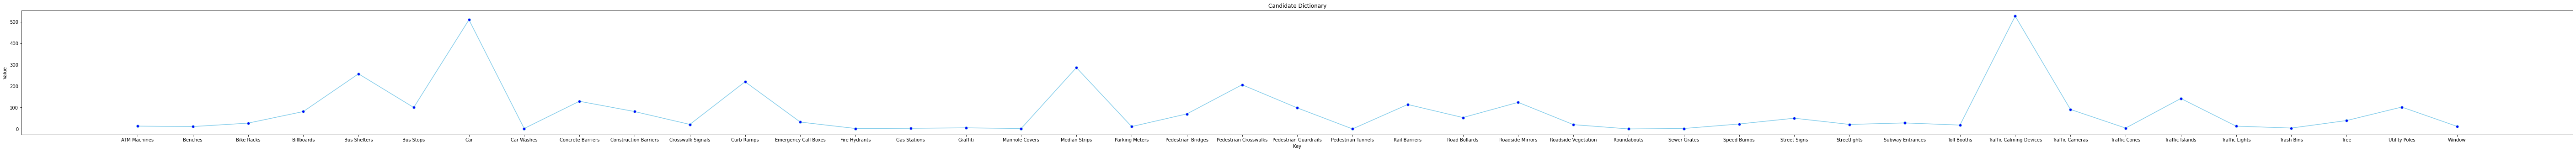

In [17]:
plot_entire_dictionary(entire_dict)

## TF-IDF

In [18]:
def TF(df):
    df = df.replace(np.nan, 0)
    df = df.sort_index(ascending=True)
    TF = df.drop(0, axis = 0)
    
    return TF


def DF(df):
    DF = TF(df).astype(bool).sum(axis = 0)
    
    return DF


def IDF(df):
    IDF = np.log(len(TF(df)) / (1+DF(df)))
    IDF = IDF.replace(np.inf, 0)
    
    return IDF


def TF_IDF(df):
    TF_IDF = TF(df) * IDF(df)
    
    return TF_IDF

In [19]:
tf = TF(df_result)

In [20]:
tf

,Car,Concrete Barriers,Utility Poles,Construction Barriers,Traffic Calming Devices,Rail Barriers,Emergency Call Boxes,Street Signs,Pedestrian Bridges,Pedestrian Crosswalks,...,Speed Bumps,Trash Bins,Manhole Covers,Traffic Cones,Benches,Car Washes,Sewer Grates,Fire Hydrants,Pedestrian Tunnels,Roundabouts
1,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,1.0,0.0,5.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,3.0,0.0,0.0,1.0,6.0,0.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df = DF(df_result)

In [22]:
df

Car                        137
Concrete Barriers           91
Utility Poles               70
Construction Barriers       34
Traffic Calming Devices    161
Rail Barriers               74
Emergency Call Boxes        22
Street Signs                28
Pedestrian Bridges          30
Pedestrian Crosswalks       94
Traffic Islands             68
Curb Ramps                 108
Bus Shelters               109
Traffic Cameras             52
Pedestrian Guardrails       64
Median Strips              122
Road Bollards               38
Billboards                  32
Bus Stops                   47
Window                      10
Subway Entrances            17
Graffiti                     5
Roadside Mirrors            58
Toll Booths                 13
Streetlights                15
Parking Meters              10
Crosswalk Signals           11
Bike Racks                  18
Gas Stations                 3
Traffic Lights               9
Roadside Vegetation         17
Tree                        25
ATM Mach

In [23]:
idf = IDF(df_result)

In [24]:
idf

Car                        0.475424
Concrete Barriers          0.880889
Utility Poles              1.139998
Construction Barriers      1.847329
Traffic Calming Devices    0.315081
Rail Barriers              1.085189
Emergency Call Boxes       2.267183
Street Signs               2.035382
Pedestrian Bridges         1.968690
Pedestrian Crosswalks      0.848800
Traffic Islands            1.168571
Curb Ramps                 0.711329
Bus Shelters               0.702197
Traffic Cameras            1.432385
Pedestrian Guardrails      1.228290
Median Strips              0.590493
Road Bollards              1.739116
Billboards                 1.906170
Bus Stops                  1.531476
Window                     3.004782
Subway Entrances           2.512306
Graffiti                   3.610918
Roadside Mirrors           1.325140
Toll Booths                2.763620
Streetlights               2.630089
Parking Meters             3.004782
Crosswalk Signals          2.917771
Bike Racks                 2

In [25]:
tf_idf = TF_IDF(df_result)

In [26]:
tf_idf

,Car,Concrete Barriers,Utility Poles,Construction Barriers,Traffic Calming Devices,Rail Barriers,Emergency Call Boxes,Street Signs,Pedestrian Bridges,Pedestrian Crosswalks,...,Speed Bumps,Trash Bins,Manhole Covers,Traffic Cones,Benches,Car Washes,Sewer Grates,Fire Hydrants,Pedestrian Tunnels,Roundabouts
1,2.377118,0.000000,0.000000,0.000000,0.630162,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.950847,0.000000,0.000000,0.000000,0.945243,0.000000,2.267183,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.426271,0.880889,0.000000,0.000000,0.315081,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.377118,0.000000,0.000000,0.000000,0.630162,2.170379,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.426271,0.000000,1.139998,0.000000,1.575405,2.170379,0.000000,0.000000,1.96869,0.848800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.475424,0.000000,0.000000,0.000000,0.315081,0.000000,0.000000,0.000000,3.93738,1.697601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,1.426271,0.000000,1.139998,0.000000,0.945243,0.000000,0.000000,0.000000,0.00000,4.244002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,0.000000,0.000000,0.000000,0.000000,0.315081,1.085189,0.000000,2.035382,1.96869,0.848800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,1.426271,0.000000,0.000000,1.847329,1.890486,0.000000,2.267183,4.070763,3.93738,0.848800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
